In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/mnp.integrated.h5ad'

adata = sc.read_h5ad(results_file)
adata

/home/jovyan/my-conda-envs/mypython3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


AnnData object with n_obs × n_vars = 793 × 3000 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'cohort', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'celltype-immune'
    var: 'gene_ids', 'feature_types'
    uns: 'celltype-immune_colors', 'cohort_colors', 'dendrogram_celltype-immune', 'dendrogram_leiden', 'group_colors', 'leiden', 'leiden_colors', 'neighbors', 'patient_colors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [2]:
# extract the genes into two new object
adat = sc.AnnData(adata.raw.X, obs = adata.obs, var = adata.raw.var, obsm = adata.obsm)
adat

AnnData object with n_obs × n_vars = 793 × 10357 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'cohort', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'celltype-immune'
    var: 'gene_ids', 'feature_types'
    obsm: 'X_pca', 'X_umap'

In [3]:
class_vector = adat.obs['celltype-immune']
gene_exp = pd.DataFrame(adat.X.toarray(), columns = adat.var.index, index = adat.obs.index).transpose()
gene_exp.reset_index(drop = False, inplace = True)

In [44]:
res.res2d.to_csv('out/GSEA/Mac-MT1_macstim_gsea_tumor_vs_normal_full.txt', sep ='\t')

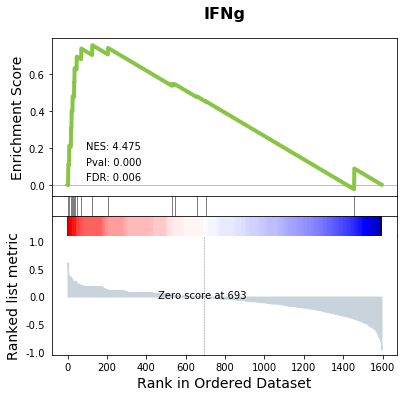

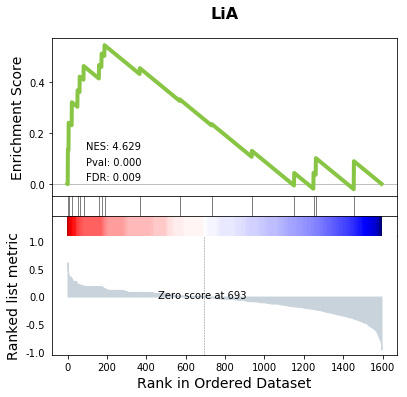

In [57]:
from gseapy.plot import gseaplot, heatmap
terms = res.res2d.index
# Make sure that ``ofname`` is not None, if you want to save your figure to disk
gseaplot(res.ranking, term=terms[0], **res.results[terms[0]])
gseaplot(res.ranking, term=terms[1], **res.results[terms[1]])

In [4]:
### run GSEA on the tumor vs normal on Mac-MT1 for just the Hallmark metabolism genes
def rankList(deg_file, remove_ribo_mito = False):
    # read in the files and do some ranking calculations
    deg = pd.read_csv(deg_file, sep = '\t', index_col = 0)
    if remove_ribo_mito:
        # remove ribosomal and mitochondrial genes
        deg = deg[~deg.index.str.contains('RPS|RPL|MT-')]

    # convert to negative log10 pval
    deg['neglog10pval'] = [-1*np.log10(p) for p in deg['pvals']]
    # convert inf values to max machine number
    try:
        deg['neglog10pval'].replace(np.inf, -1*np.log10(10**-308), inplace = True)
    except:
        pass
    try:    
        deg['neglog10pval'].replace(-np.inf, -1*np.log10(10**308), inplace = True)
    except:
        pass
    deg['rank'] = [p*np.sign(lfc) for p, lfc in zip(deg['neglog10pval'], deg['logfoldchanges'])]
    deg = deg.reset_index(drop = False)
    return(deg[['index', 'rank']])
# quickly prep the files
MacMT1 = rankList('out/DEG/tumor vs normal/Mac-MT1_tumor_vs_normal.txt', False)
Mac1 = rankList('out/DEG/tumor vs normal/Mac1_tumor_vs_normal.txt', False)
Mac2 = rankList('out/DEG/tumor vs normal/Mac2_tumor_vs_normal.txt', False)
DC = rankList('out/DEG/tumor vs normal/DC_tumor_vs_normal.txt', False)
Mono = rankList('out/DEG/tumor vs normal/Mono_tumor_vs_normal.txt', False)

In [5]:
# run preranked gsea
import gseapy as gp
pre_res = gp.prerank(rnk=MacMT1,
                     gene_sets='dataset/MDSC_mouse_converted.gmt',
                     processes=10,
                     min_size=0,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     no_plot=True,
                     verbose=True)
pre_res.res2d.to_csv('out/GSEA/Mac-MT1_mdsc_gsea_tumor_vs_normal_pr.txt', sep ='\t')

2020-04-28 13:37:47,684 Parsing data files for GSEA.............................
2020-04-28 13:37:47,689 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2020-04-28 13:37:47,690 0004 gene_sets used for further statistical testing.....
2020-04-28 13:37:47,691 Start to run GSEA...Might take a while..................
2020-04-28 13:37:48,871 Start to generate gseapy reports, and produce figures...
2020-04-28 13:37:48,880 Congratulations. GSEApy runs successfully................



In [13]:
pre_res = gp.prerank(rnk=Mac1,
                     gene_sets='dataset/MDSC_mouse_converted.gmt',
                     processes=10,
                     min_size=0,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     no_plot=True,
                     verbose=True)
pre_res.res2d.to_csv('out/GSEA/Mac1_mdsc_gsea_tumor_vs_normal_pr.txt', sep ='\t')

2020-04-28 13:38:51,886 Parsing data files for GSEA.............................
2020-04-28 13:38:51,891 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2020-04-28 13:38:51,893 0004 gene_sets used for further statistical testing.....
2020-04-28 13:38:51,893 Start to run GSEA...Might take a while..................
2020-04-28 13:38:52,165 Start to generate gseapy reports, and produce figures...
2020-04-28 13:38:52,174 Congratulations. GSEApy runs successfully................



In [14]:
pre_res = gp.prerank(rnk=Mac2,
                     gene_sets='dataset/MDSC_mouse_converted.gmt',
                     processes=10,
                     min_size=0,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     no_plot=True,
                     verbose=True)
pre_res.res2d.to_csv('out/GSEA/Mac2_mdsc_gsea_tumor_vs_normal_pr.txt', sep ='\t')

2020-04-28 13:38:56,105 Parsing data files for GSEA.............................
2020-04-28 13:38:56,112 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2020-04-28 13:38:56,113 0004 gene_sets used for further statistical testing.....
2020-04-28 13:38:56,113 Start to run GSEA...Might take a while..................
2020-04-28 13:38:56,387 Start to generate gseapy reports, and produce figures...
2020-04-28 13:38:56,395 Congratulations. GSEApy runs successfully................



In [15]:
pre_res = gp.prerank(rnk=DC,
                     gene_sets='dataset/MDSC_mouse_converted.gmt',
                     processes=10,
                     min_size=0,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     no_plot=True,
                     verbose=True)
pre_res.res2d.to_csv('out/GSEA/DC_mdsc_gsea_tumor_vs_normal_pr.txt', sep ='\t')

2020-04-28 13:39:03,207 Parsing data files for GSEA.............................
2020-04-28 13:39:03,212 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2020-04-28 13:39:03,213 0004 gene_sets used for further statistical testing.....
2020-04-28 13:39:03,214 Start to run GSEA...Might take a while..................
2020-04-28 13:39:03,455 Start to generate gseapy reports, and produce figures...
2020-04-28 13:39:03,463 Congratulations. GSEApy runs successfully................



In [16]:
pre_res = gp.prerank(rnk=Mono,
                     gene_sets='dataset/MDSC_mouse_converted.gmt',
                     processes=10,
                     min_size=0,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     no_plot=True,
                     verbose=True)
pre_res.res2d.to_csv('out/GSEA/Mono_mdsc_gsea_tumor_vs_normal_pr.txt', sep ='\t')

2020-04-28 13:39:11,692 Parsing data files for GSEA.............................
2020-04-28 13:39:11,697 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2020-04-28 13:39:11,698 0004 gene_sets used for further statistical testing.....
2020-04-28 13:39:11,699 Start to run GSEA...Might take a while..................
2020-04-28 13:39:11,971 Start to generate gseapy reports, and produce figures...
2020-04-28 13:39:11,979 Congratulations. GSEApy runs successfully................



In [18]:
gs = pd.read_csv('dataset/MDSC_mouse_converted.csv')
gs

,GMDSC,Neut,MMDSC,Mono
0,IFITM2,CAMP,IFITM2,CD74
1,IL1B,LTF,CSTA,HLA-DQB1
2,SRGN,CHIA,IL1B,CAMP
3,CSTA,CYBB,CSTA,HSPA1A
4,CSTA,CEBPE,LRG1,HLA-DMA
...,...,...,...,...
195,UBALD2,ITGB2,CALM2,NaN
196,BST1,PABPC1L,CBR3,NaN
197,PI16,ACVRL1,SLFN12,NaN
198,SYF2,FMO5,CTNNBIP1,NaN


In [19]:
for g in gs.columns:
    sc.tl.score_genes(adata, gs[g], score_name = str(g)+'_score', use_raw = True)

computing score 'GMDSC_score'
    finished: added
    'GMDSC_score', score of gene set (adata.obs) (0:00:00)
computing score 'Neut_score'
    finished: added
    'Neut_score', score of gene set (adata.obs) (0:00:00)
computing score 'MMDSC_score'
    finished: added
    'MMDSC_score', score of gene set (adata.obs) (0:00:00)
computing score 'Mono_score'
    finished: added
    'Mono_score', score of gene set (adata.obs) (0:00:00)


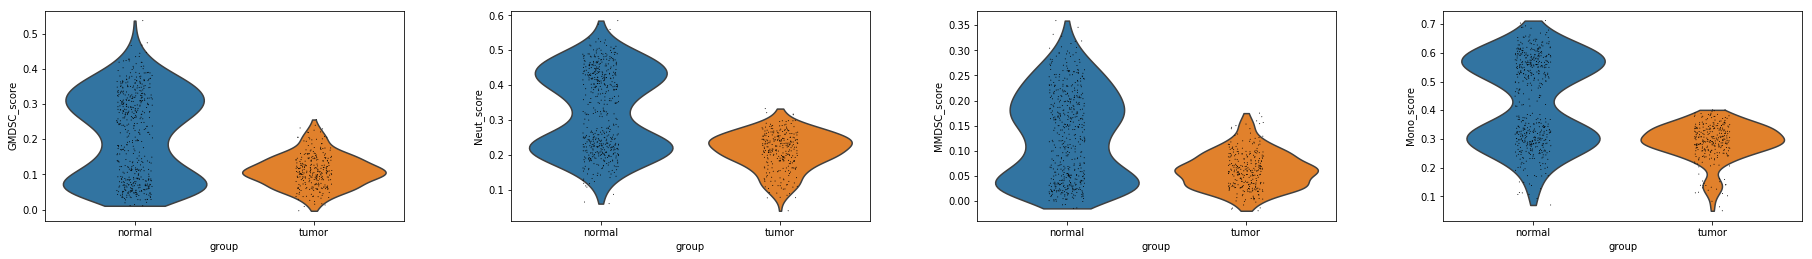

In [21]:
sc.pl.violin(adata, [str(g)+'_score' for g in gs.columns], groupby = 'group')

In [24]:
df = adata.obs[['celltype-immune','group','GMDSC_score', 'Neut_score', 'MMDSC_score', 'Mono_score']]

In [26]:
df.to_csv('figures/genesettest/mdsc_res.csv')